Text(0.5, 1.0, 'Count of Defect Classes')

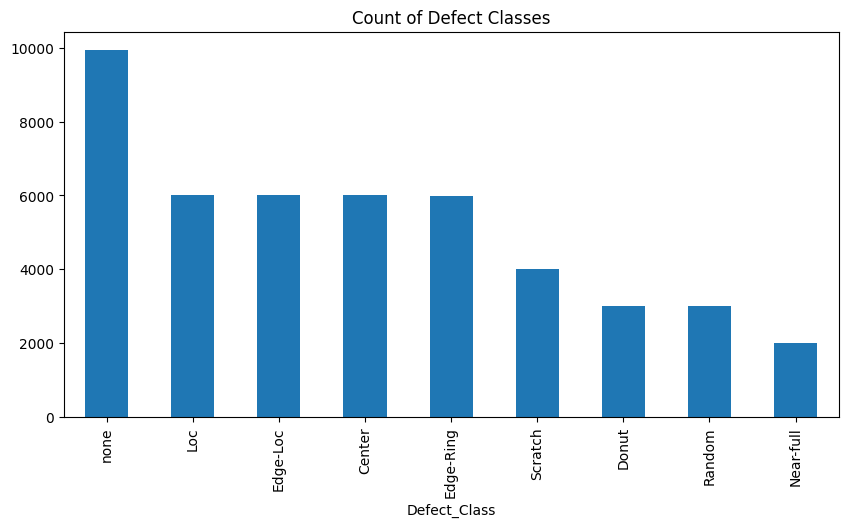

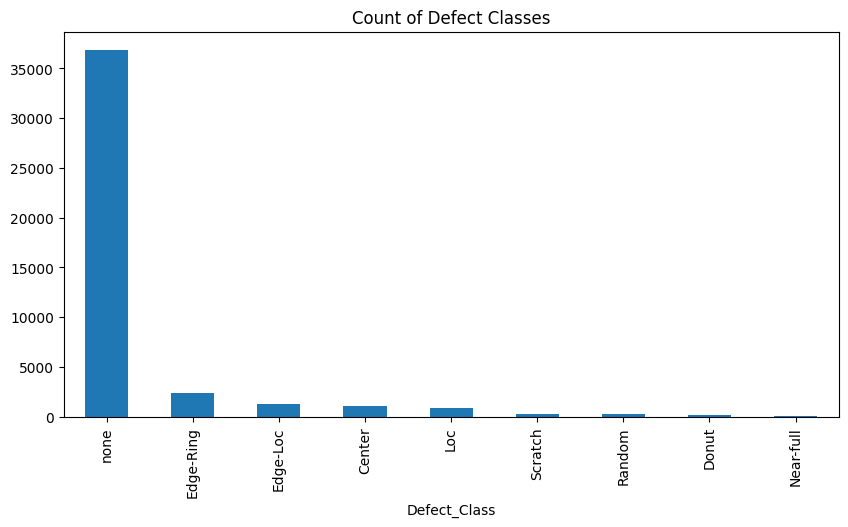

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Import Clean data
# clean_df = pd.read_pickle("train_set.pkl")
# val_df = pd.read_pickle("val_set.pkl")

# Convert NumPy arrays to JSON before saving
# clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: json.dumps(x.tolist()))
# val_df['Wafer_Map'] = val_df['Wafer_Map'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
# clean_df.to_csv("train_set.csv", index=False)
# val_df.to_csv("val_set.csv", index=False)

# Import Clean data
clean_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('val_set.csv')

# Decode JSON to NumPy arrays
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: np.array(json.loads(x), dtype=np.uint8))
val_df['Wafer_Map'] = val_df['Wafer_Map'].apply(lambda x: np.array(json.loads(x), dtype=np.uint8))

# Visualize count of each class in Defect_Class
plt.figure(figsize=(10,5))
clean_df['Defect_Class'].value_counts().plot(kind='bar')
plt.title('Count of Defect Classes')

# Visualize count of each class in Defect_Class
plt.figure(figsize=(10,5))
val_df['Defect_Class'].value_counts().plot(kind='bar')
plt.title('Count of Defect Classes')

In [2]:
import tensorflow as tf

# Set GPU as default
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Avoids allocating all memory
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### CNN Models

Reloading Tuner from mobile_net_tuning\MobileNetV2_short2\tuner0.json
{'dense1_units': 256, 'activation': 'relu', 'dropout1': 0.4, 'dense2_units': 128, 'dropout2': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
1436/1436 [==============================] - 30s 17ms/step - loss: 1.6842 - categorical_accuracy: 0.3838 - precision: 0.5935 - recall: 0.1889 - val_loss: 1.6957 - val_categorical_accuracy: 0.0208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1436/1436 [==============================] - 23s 16ms/step - loss: 1.2734 - categorical_accuracy: 0.5233 - precision: 0.7115 - recall: 0.3166 - val_loss: 1.3403 - val_categorical_accuracy: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
1436/1436 [==============================] - 24s 16ms/step - loss: 1.0506 - categorical_accuracy: 0.6073 - precision: 0.7549 - recall: 0.4389 - val_loss: 1.2264 - val_categorical_accuracy: 0.8524 - val_precision: 0.00

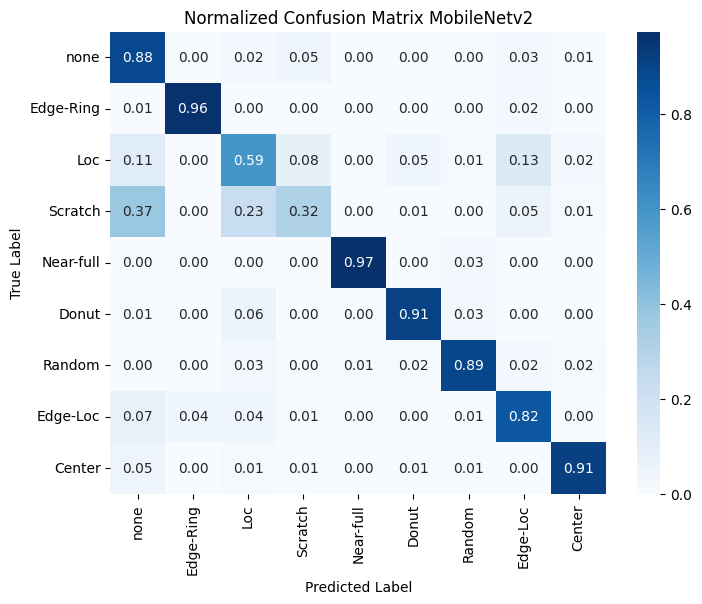

              precision    recall  f1-score   support

        none       0.99      0.88      0.93     36857
   Edge-Ring       0.91      0.96      0.94      2420
         Loc       0.37      0.59      0.46       898
     Scratch       0.05      0.32      0.08       298
   Near-full       0.88      0.97      0.92        37
       Donut       0.53      0.91      0.67       139
      Random       0.62      0.89      0.73       217
    Edge-Loc       0.45      0.82      0.58      1297
      Center       0.71      0.91      0.80      1074

    accuracy                           0.88     43237
   macro avg       0.61      0.81      0.68     43237
weighted avg       0.94      0.88      0.90     43237



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

random_state = 1

# Prepare data
X_train = np.stack(clean_df['Wafer_Map'].values)  
X_train = X_train.reshape(-1, 45, 45, 1).astype('float32')  
X_test = np.stack(val_df['Wafer_Map'].values)  
X_test = X_test.reshape(-1, 45, 45, 1).astype('float32') 

# Greyscale to RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Encode target variable
label_encoder = pd.factorize(clean_df['Defect_Class'])
y_train = label_encoder[0]
y_classes = label_encoder[1]
y_test = val_df['Defect_Class'].map({cls: i for i, cls in enumerate(y_classes)}).fillna(-1).astype(int).values

# Convert to OHE
y_train = to_categorical(y_train, num_classes=len(y_classes))
y_test = to_categorical(y_test, num_classes=len(y_classes))

# Build model
def build_model(hp):
    base_model = MobileNetV2(input_shape=(45, 45, 3), include_top=False, weights=None)
    base_model.trainable = True
    model = Sequential([
        # Transfer Learning
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),

        # Dense Layers
        Dense(hp.Choice('dense1_units', values=[256]), activation=hp.Choice("activation", ["relu"])),
        Dropout(hp.Choice('dropout1', values=[0.4])), 
        Dense(hp.Choice('dense2_units', values=[128]), activation=hp.Choice("activation", ["relu"])),
        Dropout(hp.Choice('dropout2', values=[0.2])),
        Dense(9, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',metrics=['categorical_accuracy', Precision(), Recall()])
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_categorical_accuracy',
    max_epochs=30,
    factor=3,
    directory='mobile_net_tuning',
    project_name='MobileNetV2_short2'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tune
tuner.search(X_train_rgb, y_train, epochs=30, batch_size=32, validation_data=(X_test_rgb, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

# Start time
import time
start_time = time.time()

# Train
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_rgb, y_train, epochs=50, batch_size=32, 
    validation_data=(X_test_rgb, y_test), callbacks=[early_stopping])

# End time
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Evalute
start_time = time.time()
eval_results = best_model.evaluate(X_test_rgb, y_test)    
end_time = time.time()
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")
print(f"Validation Accuracy: {eval_results[1]:.4f}")
print(f"Training Accuracy: {history.history['categorical_accuracy'][-1]:.4f}")

# Get predictions
y_pred = best_model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix MobileNetv2')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=y_classes))


In [4]:
# Show Model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_45 (Functi  (None, 2, 2, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        